# Naive models

Implements 2 naive models:  
- NaiveLag
- NaiveRollingMean

In [1]:
import seaborn as sns
import pandas as pd

import utils.utils as utils
import utils.utils_preprocessing as utils_preprocessing
import utils.utils_plots as utils_plots
import utils.constants as constants
from utils.utils_models import NaiveRollingMean, NaiveLag

sns.set_theme(style="darkgrid")

In [2]:
df_kaggle = utils_preprocessing.load_and_preprocess(constants.file_path)

/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["first_nonzero_signal"] = df.groupby(coll_agg)["signal_above_zero"].cumsum() > 0
/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["feature_periods"] = df.groupby(coll_agg).cumcount() + 1


### Validate the last 13*2 weeks

In [3]:
fc_model_rolling = NaiveRollingMean(hyperparameters={'window': 4}, bottom_up=False)
results_cv = fc_model_rolling.cross_validate(df_kaggle, n_splits=2)

Average RMSE from cross-validation: 69.4020


In [4]:
fc_model_lag = NaiveLag(hyperparameters={'lag': 13}, bottom_up=False)
results_cv = fc_model_lag.cross_validate(df_kaggle, n_splits=2)

Average RMSE from cross-validation: 73.7170


/Users/matteogiaretti/Python/hp_use_case/utils/utils_models.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X.sort_index().groupby(self.col_group)[self.column].last().to_dict()
/Users/matteogiaretti/Python/hp_use_case/utils/utils_models.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X.sort_index().groupby(self.col_group)[self.column].last().to_dict()


### Plot results for the last 13 weeks

In [5]:
X_train, X_test, y_train, y_test = utils.train_test_split(df_kaggle, forecasting_horizon=13, target_col="y")

In [6]:
fc_model_rolling = NaiveRollingMean(hyperparameters={'window': 4}, bottom_up=False)
fc_model_rolling.train(X_train, y_train)

fc_model_lag = NaiveLag(hyperparameters={'lag': 13}, bottom_up=False)
fc_model_lag.train(X_train, y_train)

In [7]:
df_preds_rolling = utils.predict_last_13_weeks(df_kaggle, fc_model_rolling)
df_preds_lag = utils.predict_last_13_weeks(df_kaggle, fc_model_lag)

df_final = df_kaggle.merge(df_preds_rolling.reset_index(), on=['date', 'sku'], how='left')

/Users/matteogiaretti/Python/hp_use_case/utils/utils_models.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X.sort_index().groupby(self.col_group)[self.column].last().to_dict()


In [8]:
temp = df_preds_lag.reset_index().merge(df_preds_rolling, on=['date', 'sku'], suffixes=['_lag', '_rolling'])
df_final = df_kaggle.merge(temp, on=['date', 'sku'], how='left')[['date', 'sku', 'product_number', 'year_week', 'id', 'y', 'y_pred_lag', 'y_pred_rolling']]
vline_dates = [df_final['date'].max() - pd.DateOffset(weeks=13)]

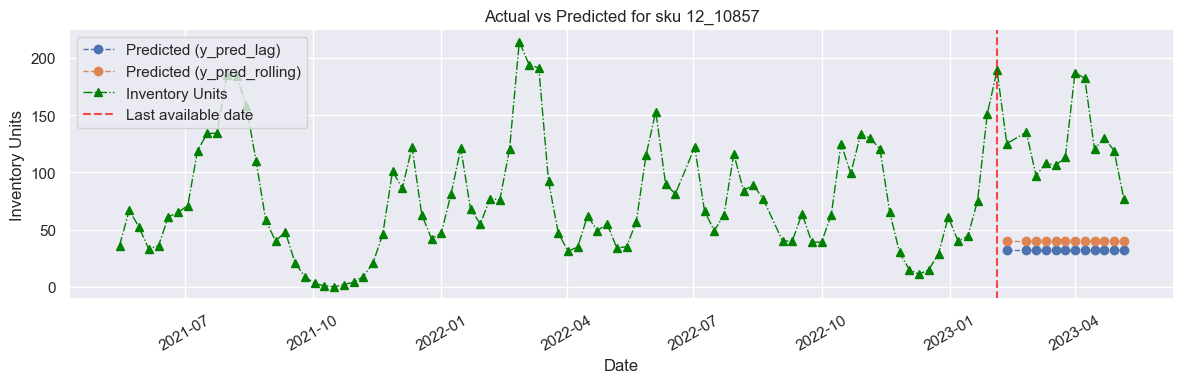

In [9]:
utils_plots.plot_real_vs_predicted(df_final, single_ts='12_10857', pred_columns=['y_pred_lag', 'y_pred_rolling'], vline_dates=vline_dates)

In [10]:
num_select = 4
#list_skus = np.random.choice(df_preds_rolling['sku'].unique(), size=num_select, replace=False) # Random
list_skus = df_preds_rolling["sku"].cat.remove_unused_categories().value_counts().index[:num_select].values # More entries in the dataset
#list_skus = df_preds_rolling["sku"].cat.remove_unused_categories().value_counts().index[-num_select:].values # Less entries in the dataset

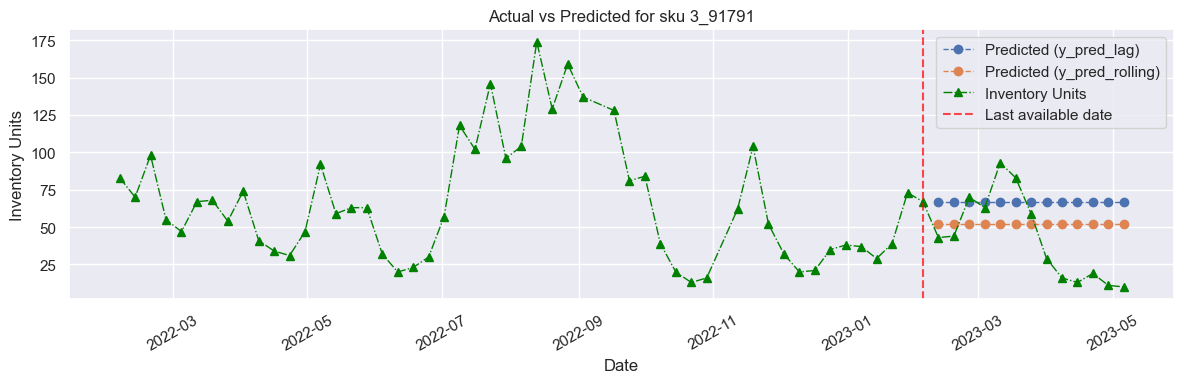

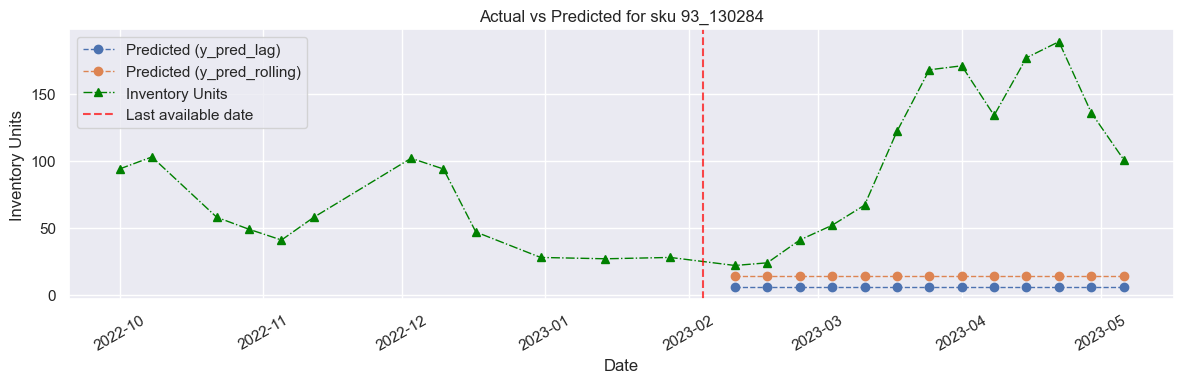

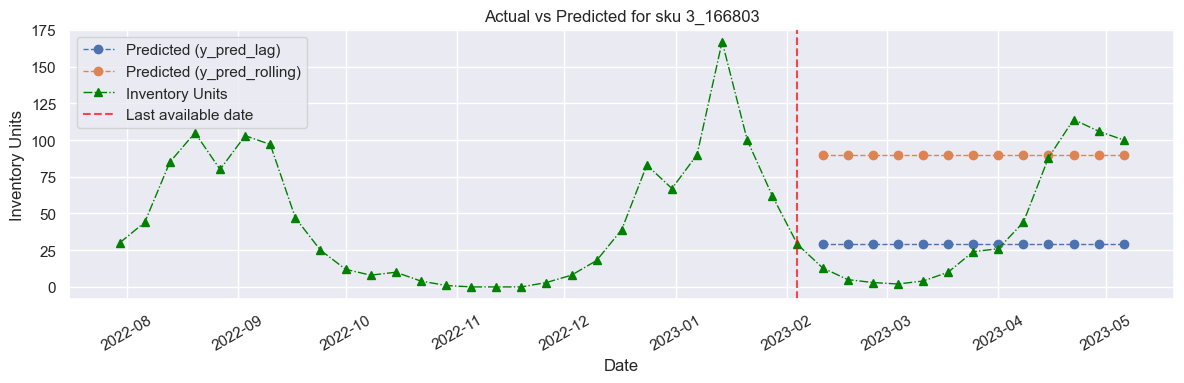

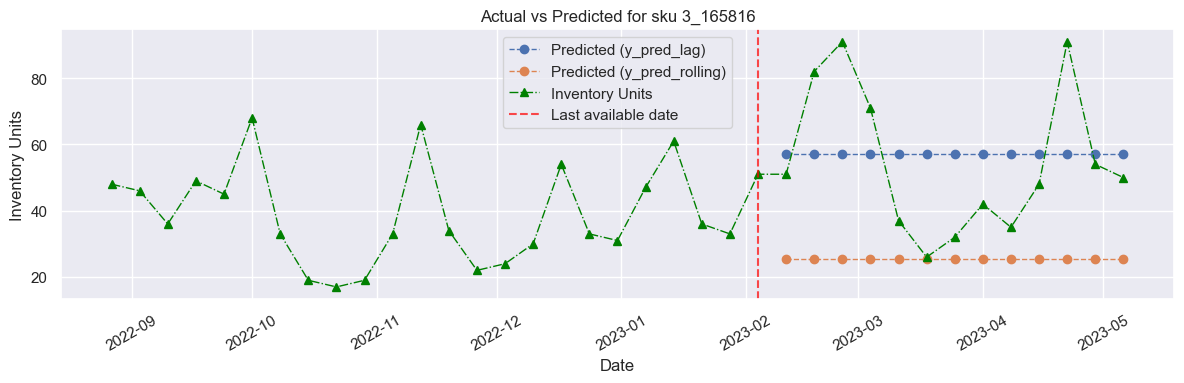

In [11]:
date_present = df_final['date'].max() - pd.DateOffset(weeks=13)
for sku in list_skus:
    utils_plots.plot_real_vs_predicted(df_final, sku, pred_columns=['y_pred_lag', 'y_pred_rolling'], vline_dates=[date_present])

### Aggregated predictions

In [12]:
df_aggregated = utils.aggregate_predictions(df_final, cols=['y_pred_lag', 'y_pred_rolling'])

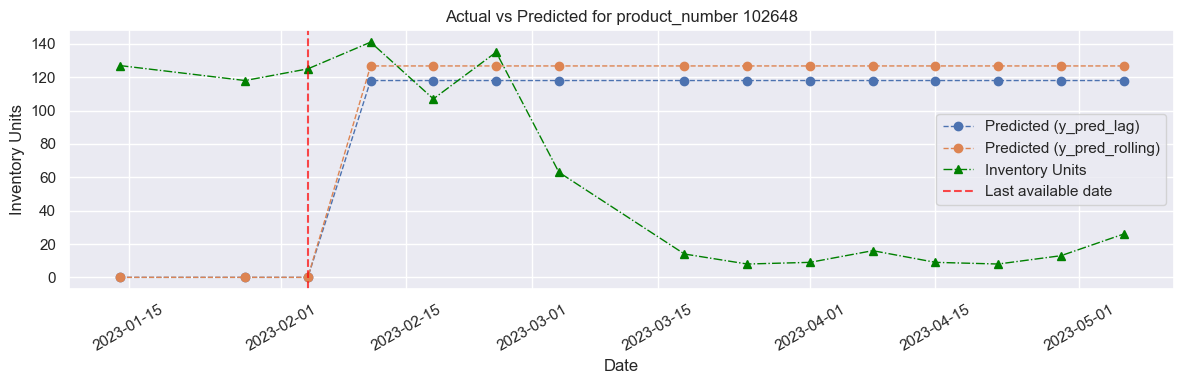

In [13]:
utils_plots.plot_real_vs_predicted(df_aggregated, single_ts=102648, pred_columns=['y_pred_lag', 'y_pred_rolling'], col_agg='product_number', vline_dates=[date_present])